In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

In [ ]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))

In [ ]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)

In [ ]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(32, activation='relu', name='hidden-layer-2'),
    tf.keras.layers.Dense(16, activation='relu', name='hidden-layer-3'),
    tf.keras.layers.Dense(1, name='output-layer')
])

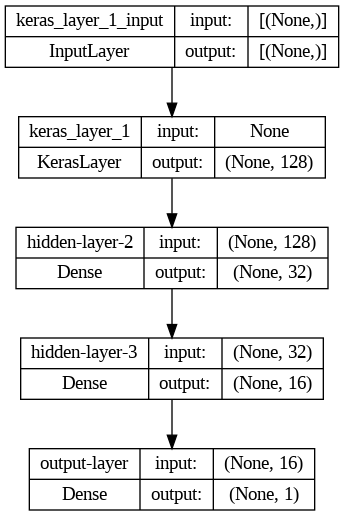

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 hidden-layer-2 (Dense)      (None, 32)                4128      
                                                                 
 hidden-layer-3 (Dense)      (None, 16)                528       
                                                                 
 output-layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 124647361 (475.49 MB)
Trainable params: 124647361 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=5,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/5
30/30 [==============================] - 11s 214ms/step - loss: 0.7232 - accuracy: 0.6325 - val_loss: 0.5780 - val_accuracy: 0.7499
Epoch 2/5
30/30 [==============================] - 5s 169ms/step - loss: 0.4085 - accuracy: 0.8315 - val_loss: 0.4918 - val_accuracy: 0.8352
Epoch 3/5
30/30 [==============================] - 6s 196ms/step - loss: 0.2579 - accuracy: 0.9123 - val_loss: 0.3613 - val_accuracy: 0.8651
Epoch 4/5
30/30 [==============================] - 6s 190ms/step - loss: 0.1557 - accuracy: 0.9549 - val_loss: 0.4208 - val_accuracy: 0.8821
Epoch 5/5
30/30 [==============================] - 5s 147ms/step - loss: 0.0997 - accuracy: 0.9741 - val_loss: 0.4489 - val_accuracy: 0.8856


In [ ]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 2s - loss: 0.5252 - accuracy: 0.8628 - 2s/epoch - 48ms/step
loss: 0.525
accuracy: 0.863


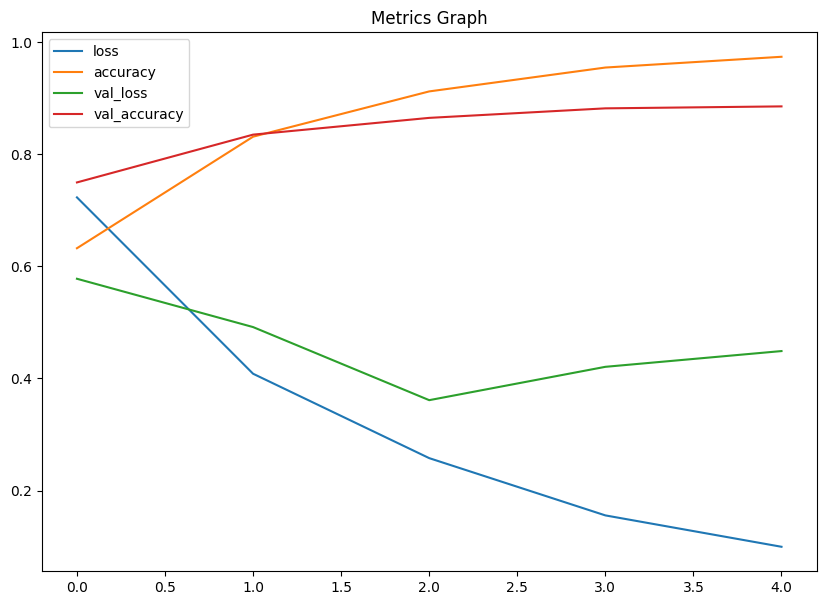

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.title("Metrics Graph")
plt.show()

In [ ]:
texts = []
true_labels = []
for text, label in test_data:
    texts.append(text.numpy())
    true_labels.append(label.numpy())
texts = np.array(texts)
true_labels = np.array(true_labels)

In [ ]:
predicted_probs = model.predict(texts)

782/782 [==============================] - 6s 8ms/step


In [ ]:
predicted_labels = (predicted_probs > 0.5).astype(int)

In [ ]:
report = metrics.classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.84      0.90      0.87     12500
    Positive       0.89      0.83      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



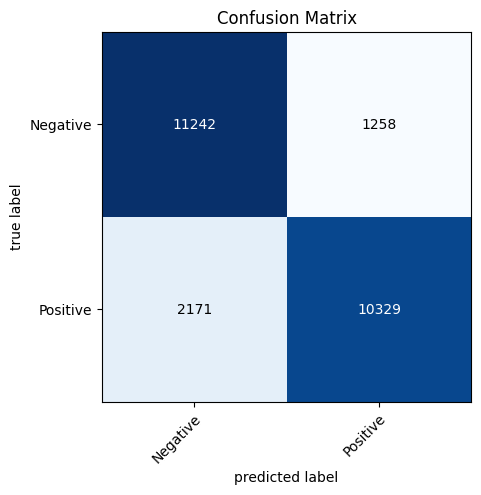

In [ ]:
cm = metrics.confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(cm, class_names=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.show()